In [1]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)

In [23]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'C:/Study/Project/60_days_ML/54/COVID-19_Radiography_Dataset'
source_dirs = ['normal', 'viral', 'covid']
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
for i, d in enumerate(source_dirs):
    os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
for c in class_names:
    os.mkdir(os.path.join(root_dir, 'test', c))
for c in class_names:
    images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
    selected_images = random.sample(images, 30)
    for image in selected_images:
        source_path = os.path.join(root_dir, c, image)
        target_path = os.path.join(root_dir, 'test', c, image)
        shutil.move(source_path, target_path)
class cds(torch.utils.data.Dataset):
    def __init__(self,image_dirs,transform):
        def gi(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower()]
            return images
        self.images ={}
        self.class_names = ['normal','viral','covid']
        
        for c in self.class_names:
            self.images[c] = gi(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        index = index % len( self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)

In [24]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std= [0.229,0.224,0.225])
    
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std= [0.229,0.224,0.225])
    
])

In [26]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}
train_dataset = cds(train_dirs,train_transform)
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}
test_dataset = cds(test_dirs,test_transform)
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

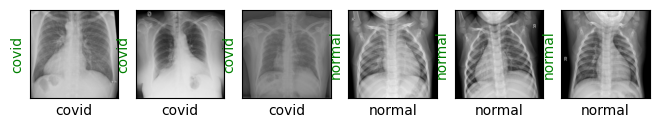

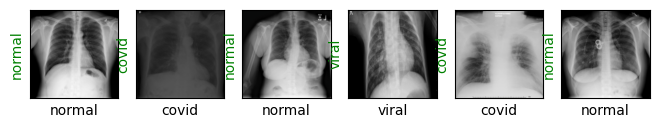

In [27]:
class_names = train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
images, labels = next(iter(dl_train))
show_images(images, labels, labels)
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

c:\App\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\App\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:11<00:00, 4.01MB/s]


In [31]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
train_loss = 0.
val_loss = 0.
resnet18.train() # set model to training phase
for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
            accuracy = 0
            resnet18.eval() # set model to eval phase
            for val_step, (images, labels) in enumerate(dl_test):
                outputs = resnet18(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                accuracy += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
resnet18.train()

Evaluating at step 0
Validation Loss: 0.9419, Accuracy: 0.0333
Validation Loss: 1.0740, Accuracy: 0.0226
Validation Loss: 0.7281, Accuracy: 0.0225
Validation Loss: 0.4767, Accuracy: 0.0114
Validation Loss: 0.3342, Accuracy: 0.0223
Validation Loss: 0.2390, Accuracy: 0.0114
Validation Loss: 0.1878, Accuracy: 0.0335
Validation Loss: 0.1612, Accuracy: 0.0226
Validation Loss: 0.1286, Accuracy: 0.0336
Validation Loss: 0.1195, Accuracy: 0.0115
Validation Loss: 0.1128, Accuracy: 0.0223
Validation Loss: 0.0991, Accuracy: 0.0447
Validation Loss: 0.0825, Accuracy: 0.0561
Validation Loss: 0.0750, Accuracy: 0.0228
Validation Loss: 0.0795, Accuracy: 0.0225
Validation Loss: 1.1223, Accuracy: 0.0333
Validation Loss: 1.0653, Accuracy: 0.0226
Validation Loss: 0.6501, Accuracy: 0.0447
Validation Loss: 0.3881, Accuracy: 0.0561
Validation Loss: 0.2893, Accuracy: 0.0340
Validation Loss: 0.2438, Accuracy: 0.0004
Validation Loss: 0.1783, Accuracy: 0.0444
Validation Loss: 0.1387, Accuracy: 0.0227
Validation Lo